In [38]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nehalbirla/vehicle-dataset-from-cardekho")

print("Path to dataset files:", path)

c:\Users\Юзер\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 292k/292k [00:00<00:00, 502kB/s]

Extracting files...
Path to dataset files: C:\Users\Юзер\.cache\kagglehub\datasets\nehalbirla\vehicle-dataset-from-cardekho\versions\4


DESCRIBE OF DATASE  

This dataset contains information about used cars.
This data can be used for a lot of purposes such as price prediction to exemplify the use of linear regression in Machine Learning.
The columns in the given dataset are as follows:

1) name
2) year
3) selling_price
4) km_driven
5) fuel
6) seller_type
7) transmission
8) Owner

Задача:

Задача регрессии - необходимо, опираясь на параметры автомобиля, предсказать его цену 

Будет попытка применить разные модели и произвести feature selection(хотя здесь это особо и не требуется)

Основная метрика - MSE



In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

df = pd.read_csv('car details v3.csv')
df.head(3)


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0


In [2]:
df.shape

(8128, 13)

Проверим какие ячейки с Nan

In [3]:
df.isna().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

Просто удалим эти ячейки, потому что их ненмого относительно размера всего массива

In [4]:
df = df.dropna()
df.isna().sum()
df.shape

(7906, 13)

Далее в некоторых столбцах нужно избавиться от единиц измерения, чтобы было удобнее анализировать

In [5]:
df['engine'] = df['engine'].map(lambda x: ' '.join(num for num in x.split() if num.isdigit()))
df['engine'] = df['engine'].astype(int)
df['engine']

0       1248
1       1498
2       1497
3       1396
4       1298
        ... 
8123    1197
8124    1493
8125    1248
8126    1396
8127    1396
Name: engine, Length: 7906, dtype: int64

In [6]:
df['max_power'] = df['max_power'].map(lambda x: ' a'.join(num for num in x.split() if num != 'bhp'))
df['max_power'] = pd.to_numeric(df['max_power'])
df['max_power'] 

0        74.00
1       103.52
2        78.00
3        90.00
4        88.20
         ...  
8123     82.85
8124    110.00
8125     73.90
8126     70.00
8127     70.00
Name: max_power, Length: 7906, dtype: float64

In [7]:
df['mileage'] = df['mileage'].map(lambda x: ' '.join(num for num in x.split() if num != 'kmpl' and num != 'km/kg'))
df['mileage'] = pd.to_numeric(df['mileage'])
df['mileage'] 

0       23.40
1       21.14
2       17.70
3       23.00
4       16.10
        ...  
8123    18.50
8124    16.80
8125    19.30
8126    23.57
8127    23.57
Name: mileage, Length: 7906, dtype: float64

In [8]:
df['selling_price'] = df['selling_price']/1000

Немного уменьшили масштаб цен для того, чтобы с данными было удобнее работать
И посмотрим на описание столбца с ценами

In [11]:
df['selling_price'].describe()

count     7906.000000
mean       649.813721
std        813.582748
min         29.999000
25%        270.000000
50%        450.000000
75%        690.000000
max      10000.000000
Name: selling_price, dtype: float64

Нарисуем распределение некоторых важных параметров

<Axes: xlabel='selling_price', ylabel='Count'>

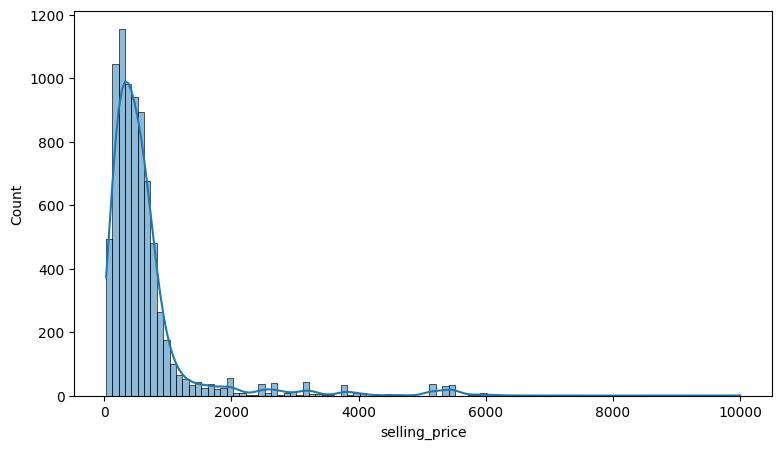

In [12]:
plt.rcParams["figure.figsize"] = (9, 5)
sns.histplot(df['selling_price'], bins = 50, binwidth=100, kde=True)

<Axes: xlabel='year', ylabel='Count'>

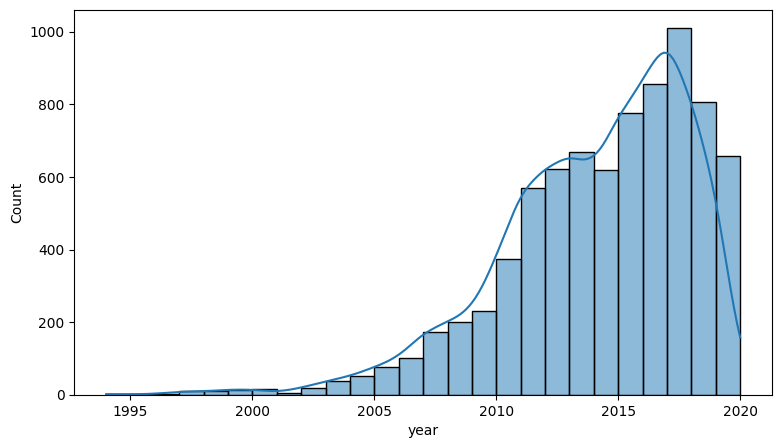

In [13]:
plt.rcParams["figure.figsize"] = (9,5)
sns.histplot(df['year'], binwidth=1,kde=True)

1458.7088287376675


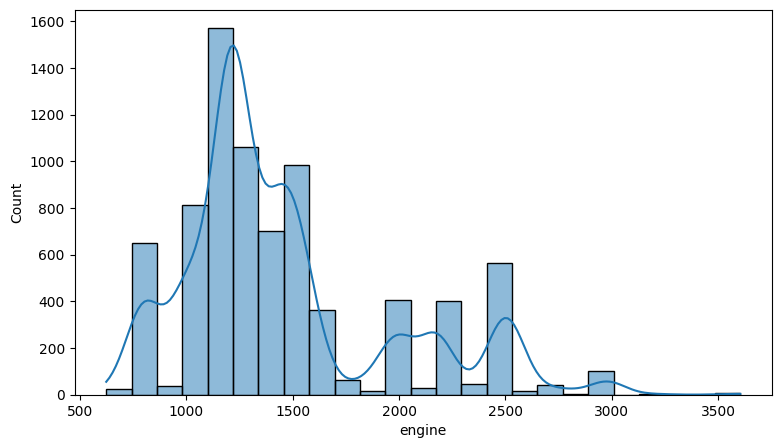

In [14]:
plt.rcParams["figure.figsize"] = (9, 5)
sns.histplot(df['engine'], binwidth=120, kde=True)
print(df['engine'].mean())

6.59462055715658


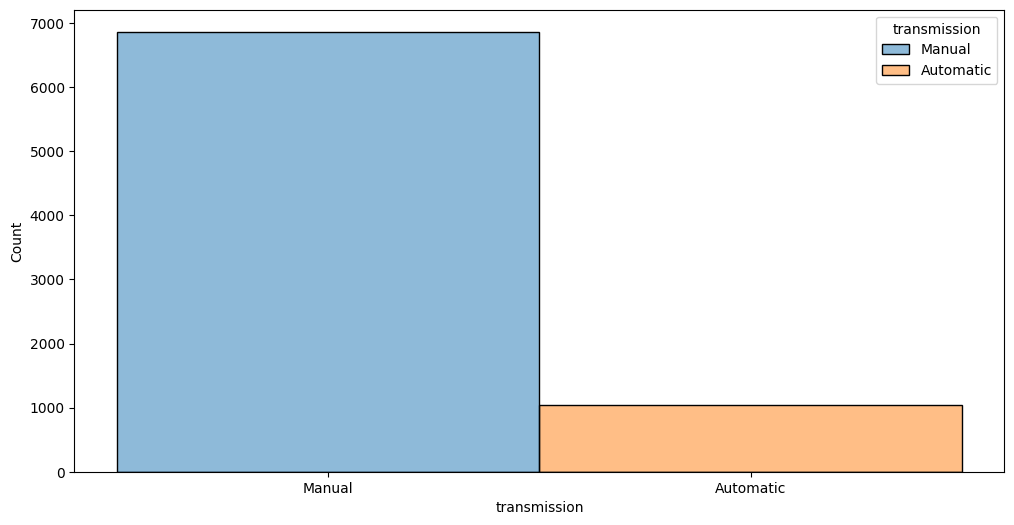

In [15]:
plt.rcParams["figure.figsize"] = (12, 6)
sns.histplot(data = df, x = 'transmission', hue='transmission')
print(df['transmission'].value_counts()['Manual']/df['transmission'].value_counts()['Automatic'])

Весьма занимательно, что на механике сильно больше автомобилей

Нарисуем парные графики зависимостей с разделение на ручную и автоматическкую транссимсию

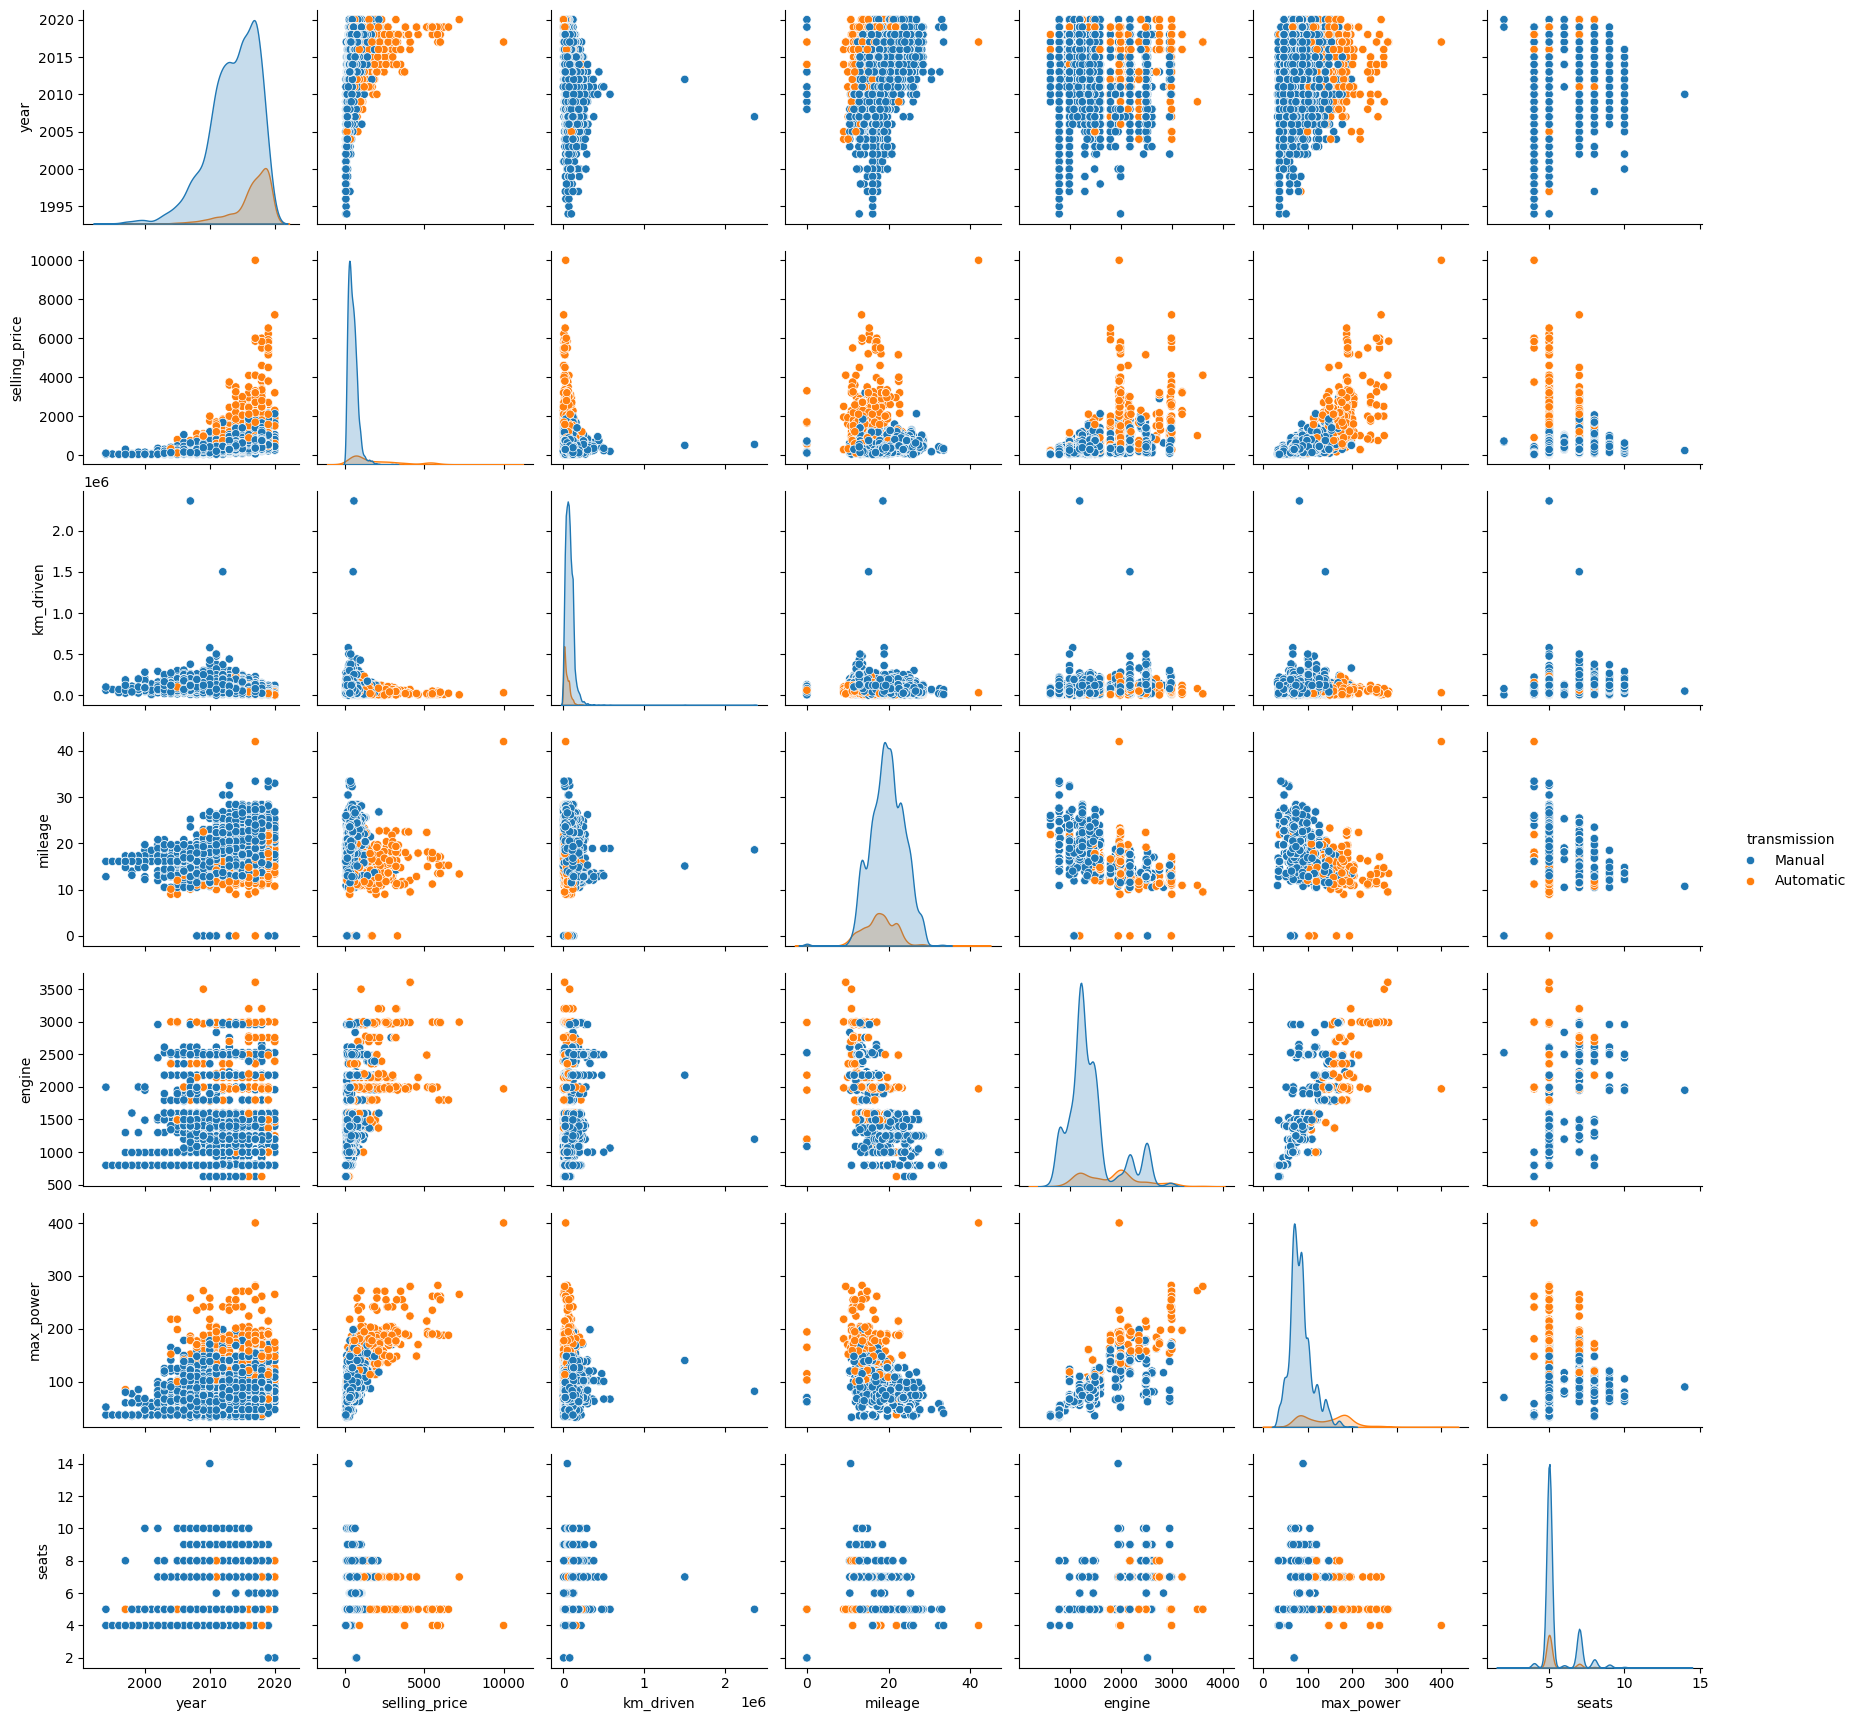

In [9]:
sns.pairplot(df, hue='transmission')

Отсюда видна явная зависимость цены автомобиля от года выпуска, мощности(которая сильно зависит от объема двигателя), пробега. Еще можно обратить внимание на то, что автомобили с АКПП стоят дороже, чем с МКПП

Нарисуем корреляционную матрицу

In [10]:
df_num = df.select_dtypes(include='number')

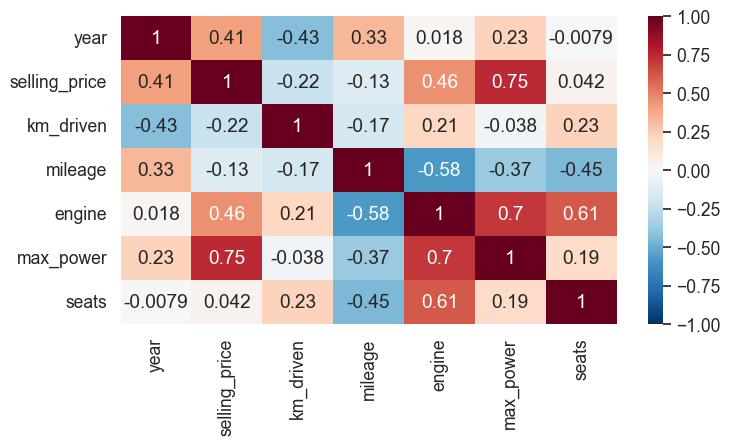

In [11]:
sns.set(font_scale=1.15)
plt.figure(figsize=(8,4))
sns.heatmap(
    df_num.corr(),        
    cmap='RdBu_r', # задаёт цветовую схему
    annot=True, # рисует значения внутри ячеек
    vmin=-1, vmax=1); # указывает начало цветовых кодов от -1 до 1.

Как и ожидалось, цена во многом зависит от мощности двигателя, года выпуска и пробега(неожиданно малая по модулю корреляция)

Далее отрисуем зависимости некоторых параметров друг от друга с нанесением на график тренда

Text(0, 0.5, 'Fuel efficiency')

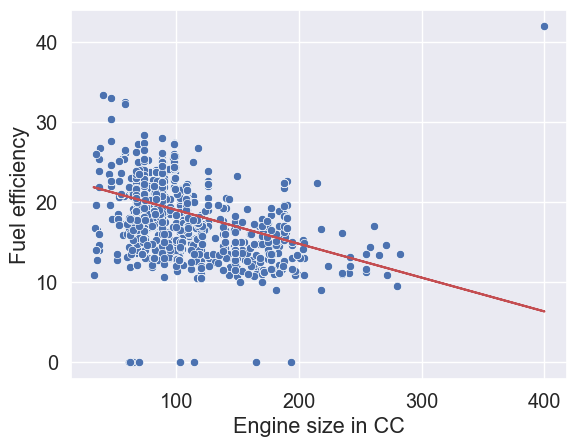

In [12]:
sns.set(font_scale=1.3)
z = np.polyfit(df['max_power'], df['mileage'], 1)
p = np.poly1d(z)

sns.scatterplot(
    x='max_power', 
    y='mileage', 
    data=df)
plt.plot(df['max_power'], p(df['max_power']), "r")
plt.xlabel(
    'Engine size in CC')
plt.ylabel(
    'Fuel efficiency')

Text(0, 0.5, 'Fuel efficiency')

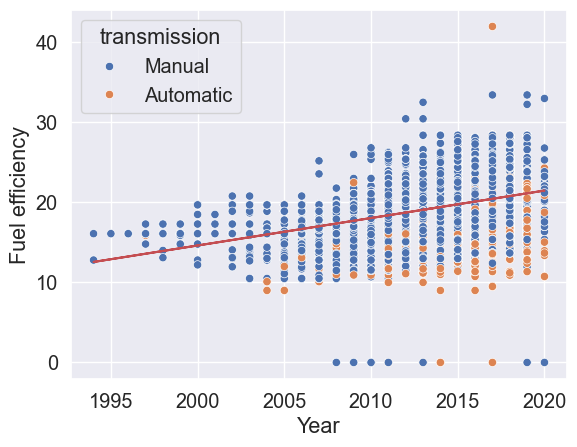

In [13]:
sns.set(font_scale=1.3)
z = np.polyfit(df['year'], df['mileage'], 1)
p = np.poly1d(z)
plt.plot(df['year'], p(df['year']), "r")
sns.scatterplot(
    x='year', 
    y='mileage',
    hue= 'transmission',
    data=df)
plt.xlabel(
    'Year')
plt.ylabel(
    'Fuel efficiency')

Text(0, 0.5, 'Price')

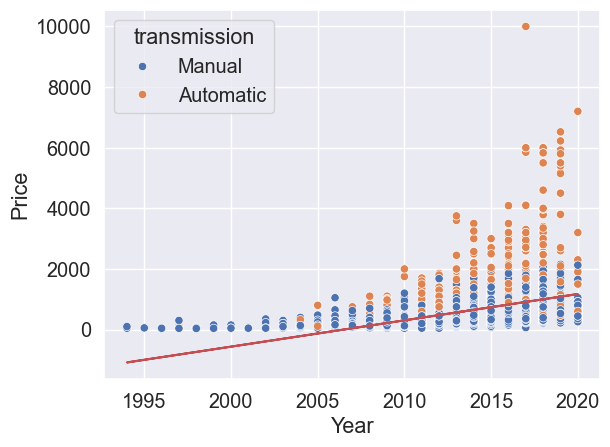

In [14]:
sns.set(font_scale=1.3)
z = np.polyfit(df['year'], df['selling_price'], 1)
p = np.poly1d(z)
plt.plot(df['year'], p(df['year']), "r")
sns.scatterplot(
    x='year', 
    y='selling_price',
    hue= 'transmission',
    data=df)
plt.xlabel(
    'Year')
plt.ylabel(
    'Price')

Text(0, 0.5, 'km')

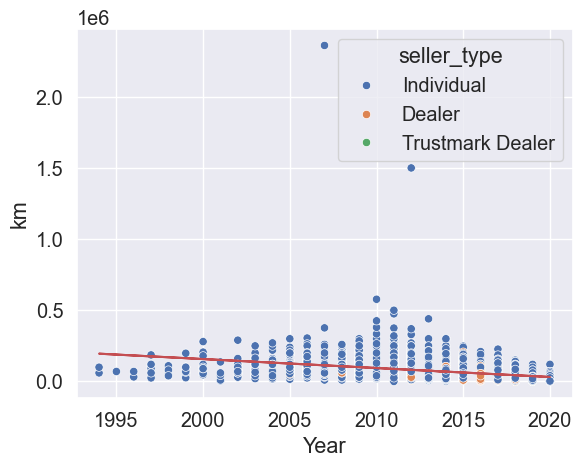

In [15]:
sns.set(font_scale=1.3)
z = np.polyfit(df['year'], df['km_driven'], 1)
p = np.poly1d(z)
plt.plot(df['year'], p(df['year']), "r")
sns.scatterplot(
    x='year', 
    y='km_driven',
    hue= 'seller_type',
    data=df)
plt.xlabel(
    'Year')
plt.ylabel(
    'km')

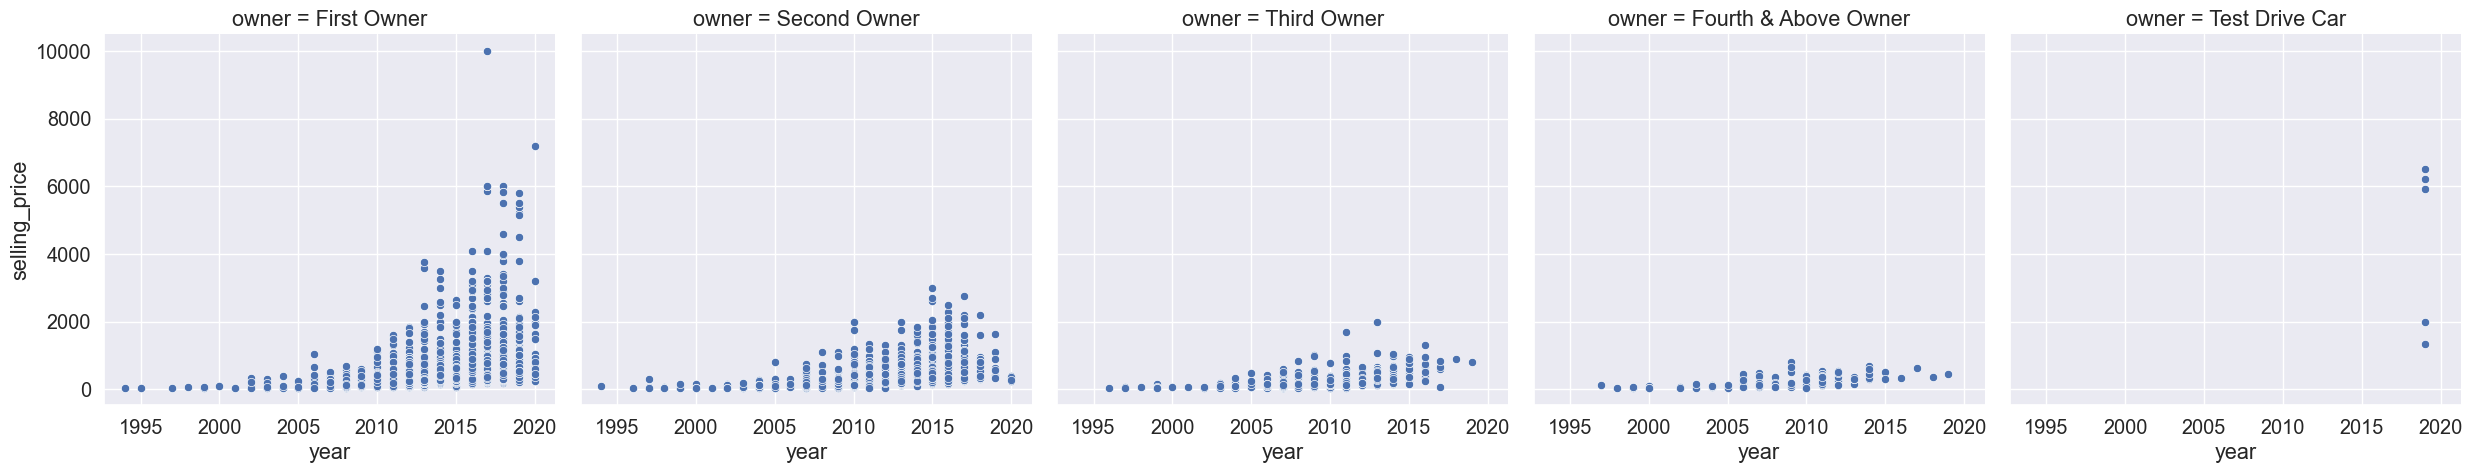

In [23]:
sns.relplot(
    x='year', 
    y='selling_price', 
    data=df, 
    kind='scatter', 
    col='owner')

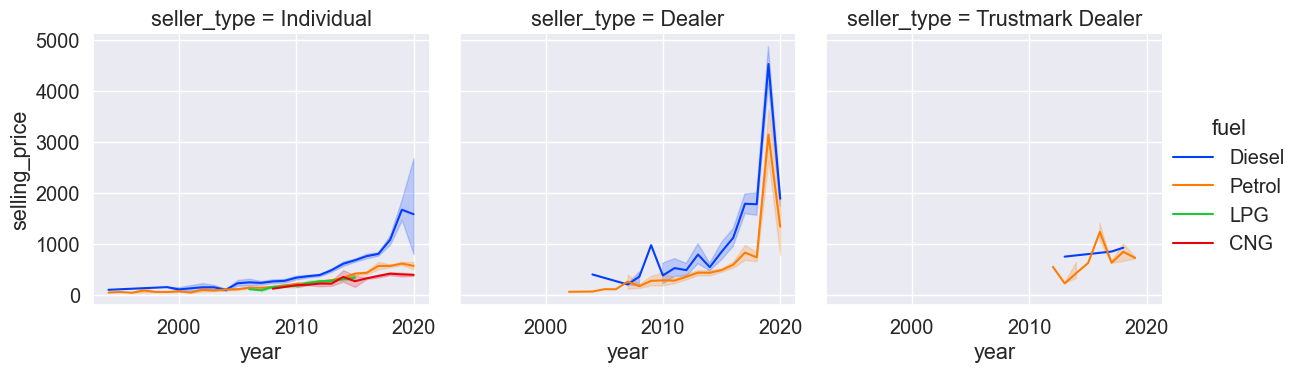

In [30]:
sns.relplot(
    x="year", 
    y="selling_price", 
    data=df,
    palette='bright', 
    height=4,
    kind='line', 
    col='seller_type',
    hue="fuel");

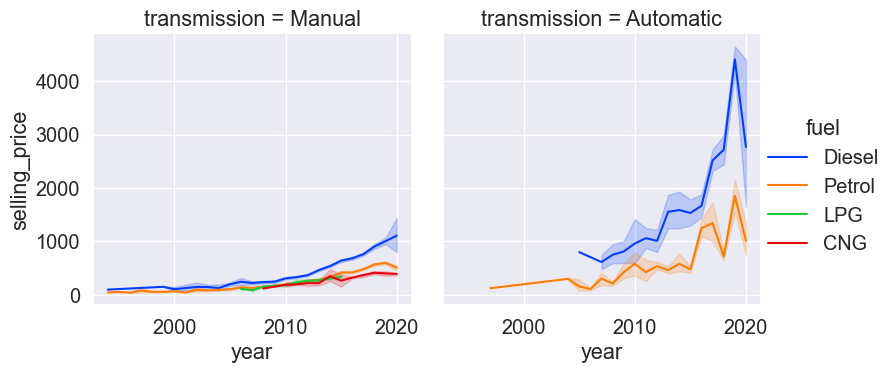

In [32]:
sns.relplot(
    x="year", 
    y="selling_price", 
    data=df,
    palette='bright', 
    height=4,
    kind='line', 
    col='transmission',
    hue="fuel");

Text(0, 0.5, 'Price')

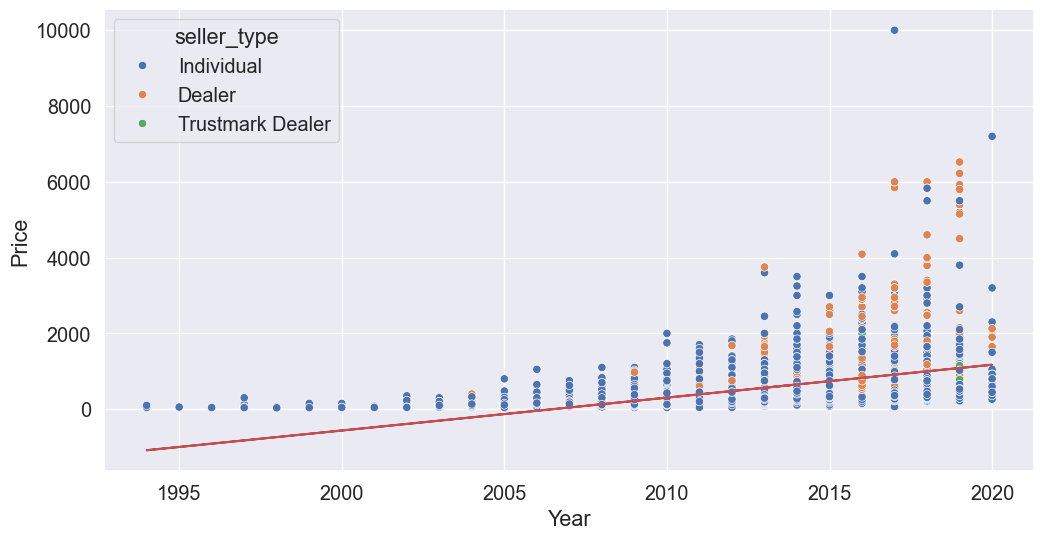

In [25]:
sns.set(font_scale=1.3)
z = np.polyfit(df['year'], df['selling_price'], 1)
p = np.poly1d(z)
plt.plot(df['year'], p(df['year']), "r")
sns.scatterplot(
    x='year', 
    y='selling_price',
    hue= 'seller_type',
    data=df)
plt.xlabel(
    'Year')
plt.ylabel(
    'Price')

Посмотрим на автомобили, которые стоят дороже всего

Добавим столбец, который задает бренд соответствующего автомобиля

C:\Users\Юзер\AppData\Local\Temp\ipykernel_9784\469611135.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Axes: xlabel='selling_price', ylabel='name'>

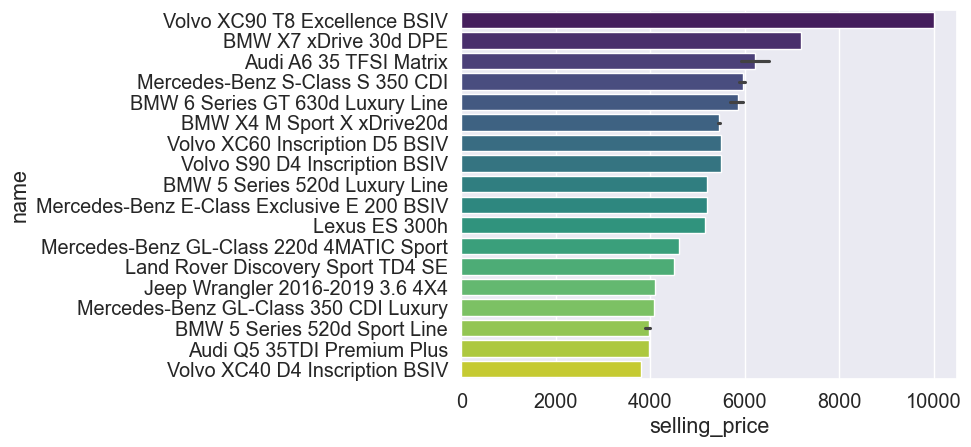

In [16]:
sns.barplot(
    x='selling_price',
    y='name',
    data=df.nlargest(150, 'selling_price'),
    palette='viridis'
)




Посмотрим на различные характеристики у разных марок автомобилей

C:\Users\Юзер\AppData\Local\Temp\ipykernel_9784\3444856745.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Axes: xlabel='selling_price', ylabel='brand'>

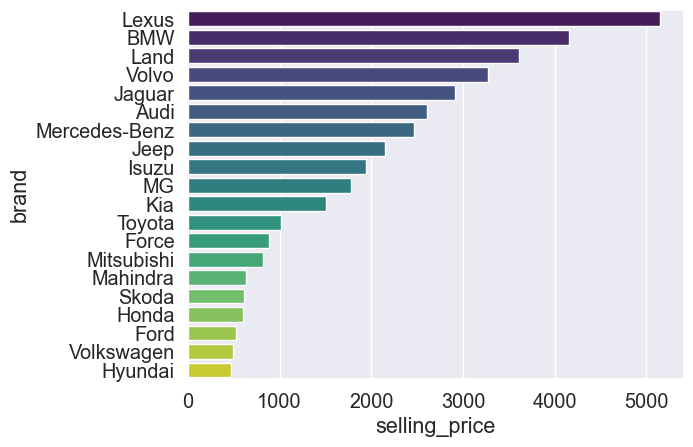

In [17]:
df['brand'] = df['name'].map(lambda x: ''.join(x.split()[0]))
br = df.groupby('brand')
mean_price = br.agg({'selling_price': 'mean'})
sns.barplot(
    x='selling_price',
    y='brand',
    data = mean_price.nlargest(20, 'selling_price'),
    palette='viridis'
)

C:\Users\Юзер\AppData\Local\Temp\ipykernel_9784\296517527.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Axes: xlabel='max_power', ylabel='brand'>

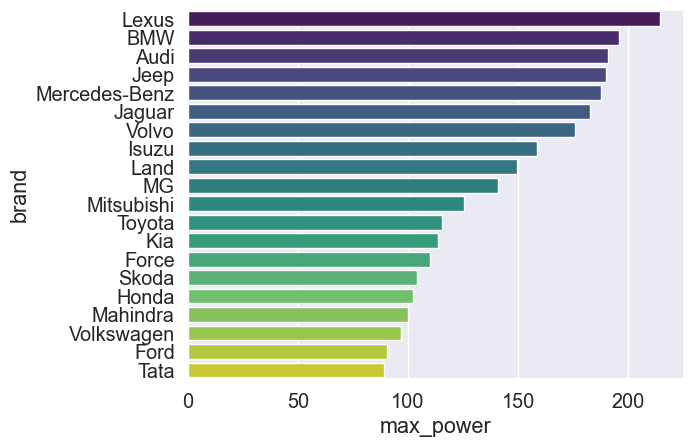

In [18]:
mean_price = br.agg({'max_power': 'mean'})
sns.barplot(
    x='max_power',
    y='brand',
    data = mean_price.nlargest(20, 'max_power'),
    palette='viridis'
)

C:\Users\Юзер\AppData\Local\Temp\ipykernel_9784\1284762248.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Axes: xlabel='km_driven', ylabel='brand'>

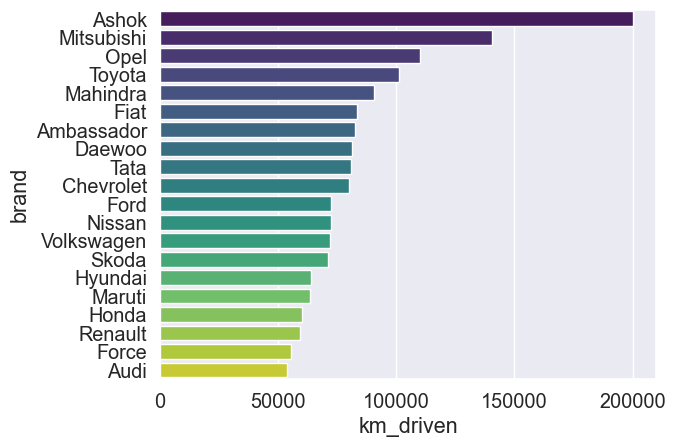

In [19]:
mean_price = br.agg({'km_driven': 'mean'})
sns.barplot(
    x='km_driven',
    y='brand',
    data = mean_price.nlargest(20, 'km_driven'),
    palette='viridis'
)

C:\Users\Юзер\AppData\Local\Temp\ipykernel_9784\2863162072.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_data[feature], y=sorted_data.index, ax=ax, palette='viridis')
C:\Users\Юзер\AppData\Local\Temp\ipykernel_9784\2863162072.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_data[feature], y=sorted_data.index, ax=ax, palette='viridis')
C:\Users\Юзер\AppData\Local\Temp\ipykernel_9784\2863162072.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_data[feature], y=sorted_data.index, ax=ax, palette='viridis'

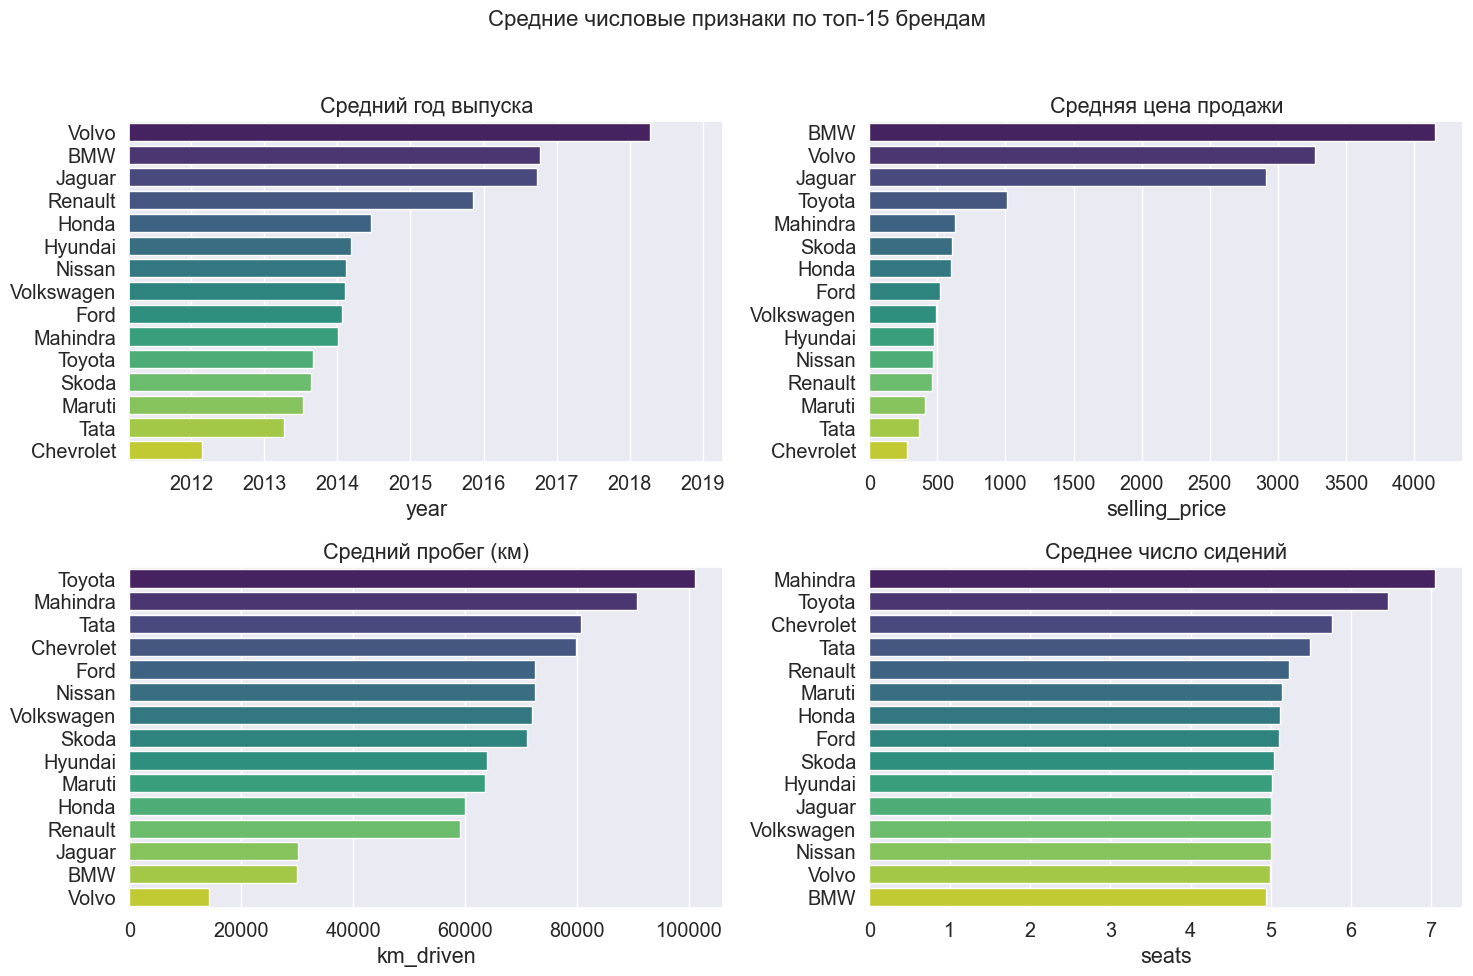

In [20]:
# Выбираем топ-15 самых популярных моделей
top_models = df['brand'].value_counts().nlargest(15).index
df_top = df[df['brand'].isin(top_models)]

# Группируем и усредняем числовые признаки
grouped = df_top.groupby('brand')[['year', 'selling_price', 'km_driven', 'seats']].mean()

# Сортировка по средней цене продажи
grouped_sorted = grouped.sort_values(by='selling_price', ascending=False)

# Настройка subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Средние числовые признаки по топ-15 брендам', fontsize=16)

# Признаки и заголовки
features = ['year', 'selling_price', 'km_driven', 'seats']
titles = ['Средний год выпуска', 'Средняя цена продажи', 'Средний пробег (км)', 'Среднее число сидений']

for ax, feature, title in zip(axs.flat, features, titles):
    # Сортировка по текущему признаку
    sorted_data = grouped.sort_values(by=feature, ascending=False)
    sns.barplot(x=sorted_data[feature], y=sorted_data.index, ax=ax, palette='viridis')
    ax.set_title(title)
    ax.set_xlabel(feature)
    ax.set_ylabel('')
    if feature == 'year':
        ax.set_xlim(grouped['year'].min() - 1, grouped['year'].max() + 1)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()